how to read a PRTFile

In [1]:
import numpy as np
file_path="/home/ivana/vnc/run/vnc.0000.prt"
tmp = "/home/ivana/vnc/run/tmp.prt"

In [2]:
header_SSP = "Depth (m)     Soundspeed (m/s)"
header_ranges = "Profile ranges (km):"

In [3]:
def remove_PIDTID(input_file_path, output_file_path, num_characters_to_remove=19):
    with open(input_file_path, 'r') as input_file, open(output_file_path, 'w') as output_file:
        for line in input_file:
            # Check if the line has at least 'num_characters_to_remove' characters
            if len(line) > num_characters_to_remove:
                # Write the line without the first 'num_characters_to_remove' characters
                output_file.write(line[num_characters_to_remove:])
            else:
                # If the line is shorter than 'num_characters_to_remove', write an empty line
                # or do not write anything if you wish to exclude short lines
                output_file.write('\n')

# Usage
remove_PIDTID(file_path, tmp)

In [4]:
def extract_numbers(file_path, keyword):
    numbers = []  # This list will store all the numbers found after the keyword
    start_collecting = False  # Flag to start collecting numbers after keyword is found

    with open(file_path, 'r') as file:
        for line in file:
            # Check if we've found the keyword
            if keyword in line:
                start_collecting = True
                continue  # Skip the keyword line

            # If we are after the keyword line, start processing for numbers
            if start_collecting:
                # Try converting the line into numbers, stop reading if it's not a number
                try:
                    # Extract numbers from the current line
                    line_numbers = [float(num) for num in line.split()]
                    if line_numbers:  # If the list is not empty
                        numbers.extend(line_numbers)
                    else:
                        # If an empty line or non-numeric line is encountered
                        break
                except ValueError:
                    # Non-numeric data encountered, stop reading
                    break

    # Convert the list of numbers to a NumPy array
    return np.array(numbers)


In [5]:
# Usage
ranges = extract_numbers(tmp, 'Profile ranges (km):')
depths_and_ssp = extract_numbers(tmp, header_SSP)
depths_and_ssp = depths_and_ssp.reshape((len(depths_and_ssp)//(len(ranges)+1)), len(ranges)+1)

In [6]:
depths = depths_and_ssp[:,0]
ssp = depths_and_ssp[:,1:]

In [9]:
depths = -1*depths

In [49]:
ssp.shape

(52, 4)

In [21]:
import matplotlib.pyplot as plt
import cmocean.cm as cm

In [28]:
from scipy.interpolate import interp2d

field = interp2d(ranges, depths, ssp, kind='linear')
nlats = np.arange(min(ranges)-1,max(ranges)+1, 10)
nZs   = np.arange(min(depths), -1, 1)

nfield = field(nlats,nZs)
Xn, Zn = np.meshgrid(nlats, nZs)

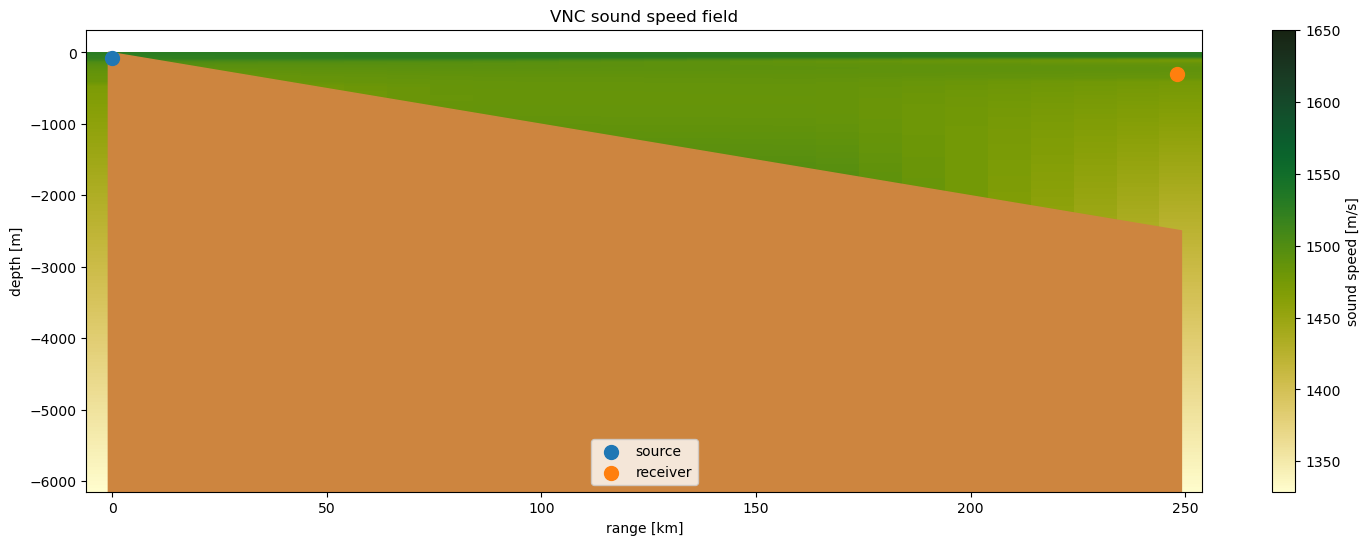

In [48]:
plt.figure(figsize=(18,6))

# SSP Field
plt.pcolormesh(Xn, Zn, nfield, cmap=cm.speed)
cbar = plt.colorbar()
cbar.ax.set_ylabel('sound speed [m/s]')

# Bathymetry: fill below the line
plt.fill_between(nlats, -10*nlats, min(nZs), color='peru')

# Source and receiver positions
plt.scatter(0, -73, label='source',s=100,zorder=1)
plt.scatter(248., -300, label='receiver',s=100)
plt.legend(loc='lower center')

# labels
plt.title('VNC sound speed field')
plt.ylabel('depth [m]')
plt.xlabel('range [km]')

# display
#plt.savefig('vnc_sound-speed_smoothed.png', bbox_inches='tight', transparent=True)
plt.show()